# 4.0 - Comparing outputs of VAE DIV and VAE TDD

In [1]:
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pickle

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(0, '../')
from sslcox.models.VariationalAE import VAE
from sslcox.data.load_datasets import load_CCLE, load_METABRIC

In [2]:
EXPRESSIONS = 'METABRIC'
FOLDER = 'METABRIC-optuna'
CV = 1 # 1-5
MODEL_TYPE = 'vae-cox'

## Loading model

In [3]:
# from: https://github.com/pytorch/pytorch/issues/16797#issuecomment-633423219
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [4]:
def load_VAE_model(MODEL_TYPE):
    with open(f'../data/training-results/{FOLDER}/CV-{CV}/{MODEL_TYPE}-model-results/VAE_model_object.pickle', 'rb') as f:
        vae_model = CPU_Unpickler(f).load()
    vae_model.device = 'cpu'

    vae_model.model = torch.load(f'../data/training-results/{FOLDER}/CV-{CV}/{MODEL_TYPE}-model-results/torch_model.pt', map_location=torch.device('cpu'))
    vae_model.model = vae_model.model.to('cpu')
    vae_model.model.device = 'cpu'

    return vae_model

## Loading training data

In [5]:
try:
    print(X.shape)

except Exception:

    expressions_load_functions = {
        'METABRIC': load_METABRIC,
    }
    data = expressions_load_functions[EXPRESSIONS]()
    expressions, meta = data

    L1000 = pd.read_csv('../data/genesets/GSE92742_Broad_LINCS_gene_info_delta_landmark.txt', sep='\t', index_col=[0])['pr_gene_symbol'].values
    X = expressions[[g for g in expressions.columns if g in L1000]]

In [6]:
kfold = KFold(5, shuffle=True, random_state=0)

for k, (train_ids, test_ids) in enumerate(kfold.split(X)):
    
    if k+1 != CV:
        continue

    X_train, X_test = X.iloc[train_ids], X.iloc[test_ids]
    std_scaler = StandardScaler()
    X_train = pd.DataFrame(std_scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(std_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

#X_train = X_test

## Calculating the output

In [7]:
def predict_decoder_outputs(model, vae_obejct, X:pd.DataFrame, y=None) -> np.ndarray:
    model.eval()
    input_X = torch.from_numpy(X[vae_obejct.feature_columns].values if type(X) == pd.DataFrame else X)
    input_X = input_X.type(torch.float32)
    y_pred = model(input_X)[0].detach().cpu().numpy()
    return y_pred

def predict_decoder_outputs_div(model, vae_obejct, X:pd.DataFrame, y=None) -> np.ndarray:
    model.eval()
    input_X = torch.from_numpy(X[vae_obejct.feature_columns].values if type(X) == pd.DataFrame else X)
    input_X = input_X.type(torch.float32)

    mean, logvar = model.encode(input_X)
    epsilon = torch.randn_like(logvar)
    z = mean + logvar*epsilon
    
    base_out = model.decoder.base_decoder(z)
    trans = model.decoder.trans_layer(base_out).detach().cpu().numpy()
    decay = model.decoder.decay_layer(base_out).detach().cpu().numpy()

    y_pred = np.concatenate((trans.reshape(trans.shape + (1,)), decay.reshape(decay.shape + (1,))), axis=-1)
    return y_pred


def predict_decoder_outputs_div_expressions(model, vae_obejct, X:pd.DataFrame, y=None) -> np.ndarray:
    model.eval()
    input_X = torch.from_numpy(X[vae_obejct.feature_columns].values if type(X) == pd.DataFrame else X)
    input_X = input_X.type(torch.float32)

    mean, logvar = model.encode(input_X)
    epsilon = torch.randn_like(logvar)
    z = mean + logvar*epsilon
    
    base_out = model.decoder.base_decoder(z)
    trans = model.decoder.trans_layer(base_out).detach().cpu().numpy()
    decay = model.decoder.decay_layer(base_out).detach().cpu().numpy()

    return trans - decay

## Outputs

In [8]:
tdd_model = load_VAE_model('vae-cox')
tdd_outputs = predict_decoder_outputs(tdd_model.model, tdd_model, X_train)
tdd_outputs_test = predict_decoder_outputs(tdd_model.model, tdd_model, X_test)
tdd_latent = tdd_model.predict_latent(X_train)

div_model = load_VAE_model('vae-div')
div_outputs = predict_decoder_outputs_div(div_model.model, div_model, X_train)
div_outputs_test = predict_decoder_outputs_div(div_model.model, div_model, X_test)
div_reconstruction = predict_decoder_outputs_div_expressions(div_model.model, div_model, X_train)
div_latent = div_model.predict_latent(X_train)

In [9]:
tdd_risk = tdd_outputs[:, :, 0]
tdd_trans = tdd_outputs[:, :, 1]
tdd_risk_test = tdd_outputs_test[:, :, 0]
tdd_trans_test = tdd_outputs_test[:, :, 1]

div_trans = div_outputs[:, :, 0]
div_decay = div_outputs[:, :, 1]
div_trans_test = div_outputs_test[:, :, 0]
div_decay_test = div_outputs_test[:, :, 1]

## Ploting model outputs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


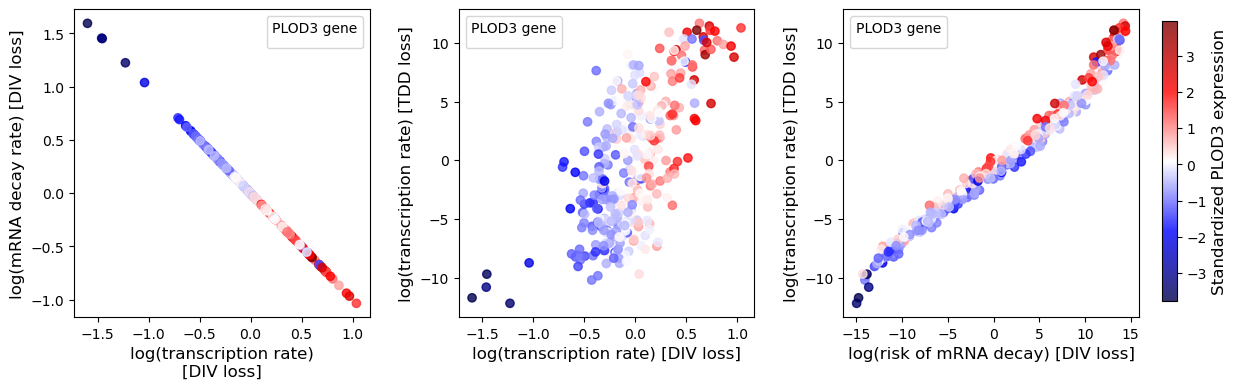

In [86]:
f, ax = plt.subplots(1, 3, figsize=(15,4), gridspec_kw={'wspace':0.3})

DIV_ID = 29
TRANS_ID = DIV_ID
TDD_ID = DIV_ID

ax[0].scatter(div_trans_test[:,DIV_ID], div_decay_test[:, DIV_ID], c=X_test.values[:, DIV_ID], cmap='seismic', alpha=0.8)
ax[0].set_xlabel('log(transcription rate)\n[DIV loss]', fontsize=12)
ax[0].set_ylabel('log(mRNA decay rate) [DIV loss]', fontsize=12)
ax[0].legend(title=f'{X_train.columns[DIV_ID]} gene')

ax[1].scatter(div_trans_test[:,TRANS_ID], tdd_trans_test[:, TRANS_ID], c=X_test.values[:, TRANS_ID], cmap='seismic', alpha=0.8)
ax[1].set_xlabel('log(transcription rate) [DIV loss]', fontsize=12)
ax[1].set_ylabel('log(transcription rate) [TDD loss]', fontsize=12)
ax[1].legend(title=f'{X_train.columns[DIV_ID]} gene')

clb = ax[2].scatter(tdd_risk_test[:, TDD_ID], tdd_trans_test[:, TDD_ID], c=X_test.values[:, TDD_ID], cmap='seismic', alpha=0.8)
ax[2].set_xlabel('log(risk of mRNA decay) [DIV loss]', fontsize=12)
ax[2].set_ylabel('log(transcription rate) [TDD loss]', fontsize=12)
ax[2].legend(title=f'{X_train.columns[DIV_ID]} gene')

f.subplots_adjust(right=0.835)
cbar_ax = f.add_axes([0.85, 0.15, 0.01, 0.7])  # Adjust the [left, bottom, width, height] as needed
cb = f.colorbar(clb, cax=cbar_ax)
cb.set_label(f'Standardized {X_train.columns[DIV_ID]} expression', fontsize=12)

Text(0, 0.5, 'log(transcription rate) [TDD loss]')

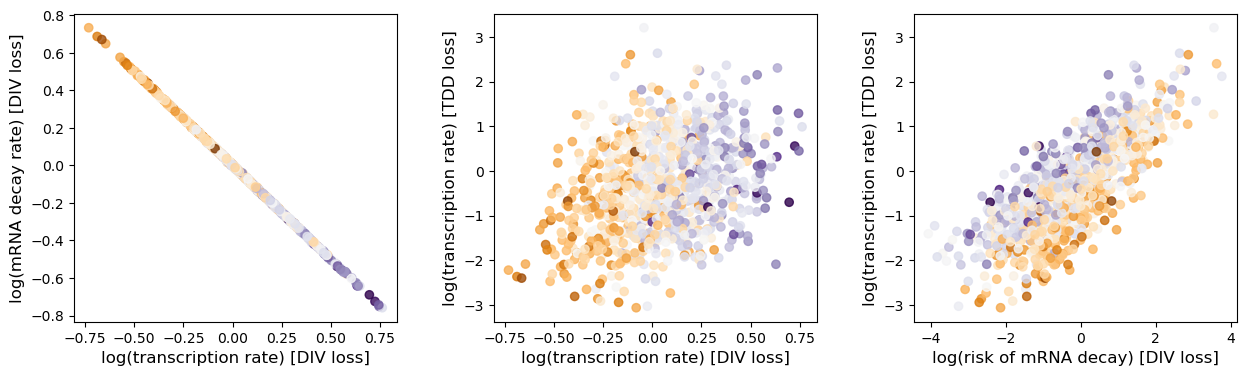

In [79]:
f, ax = plt.subplots(1, 3, figsize=(15,4), gridspec_kw={'wspace':0.3})

DIV_ID = 42
TRANS_ID = DIV_ID
TDD_ID = DIV_ID

ax[0].scatter(div_trans_test[DIV_ID], div_decay_test[DIV_ID], c=X_test.values[DIV_ID], alpha=0.8, cmap='PuOr')
ax[0].set_xlabel('log(transcription rate) [DIV loss]', fontsize=12)
ax[0].set_ylabel('log(mRNA decay rate) [DIV loss]', fontsize=12)

ax[1].scatter(div_trans_test[TRANS_ID], tdd_trans_test[TRANS_ID], c=X_test.values[TRANS_ID], alpha=0.8, cmap='PuOr')
ax[1].set_xlabel('log(transcription rate) [DIV loss]', fontsize=12)
ax[1].set_ylabel('log(transcription rate) [TDD loss]', fontsize=12)

ax[2].scatter(tdd_risk_test[TDD_ID], tdd_trans_test[TDD_ID], c=X_test.values[TDD_ID],  alpha=0.8, cmap='PuOr')
ax[2].set_xlabel('log(risk of mRNA decay) [DIV loss]', fontsize=12)
ax[2].set_ylabel('log(transcription rate) [TDD loss]', fontsize=12)

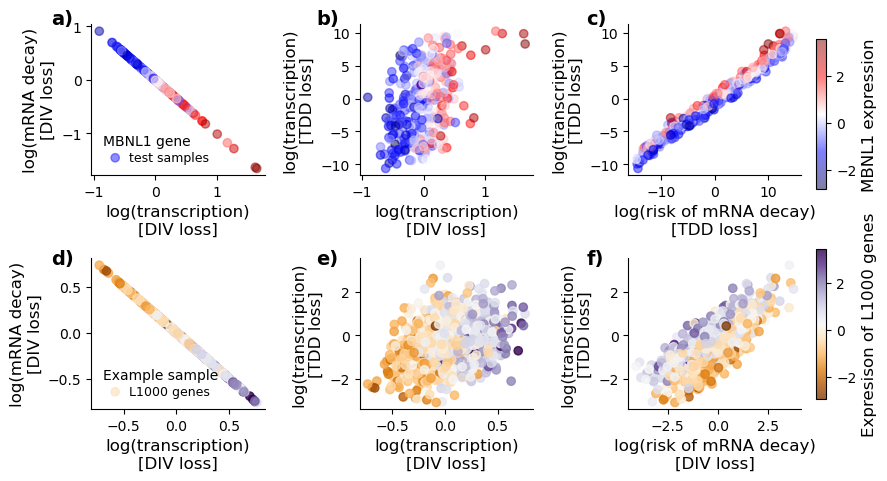

In [166]:
f, ax = plt.subplots(2, 3, figsize=(10,5), gridspec_kw={'wspace':0.55, 'hspace':0.55})

DIV_ID = 28
TRANS_ID = DIV_ID
TDD_ID = DIV_ID

ax[0][0].scatter(div_trans_test[:,DIV_ID], div_decay_test[:, DIV_ID], c=X_test.values[:, DIV_ID], cmap='seismic', alpha=0.5, label='test samples')
ax[0][0].set_xlabel('log(transcription)\n[DIV loss]', fontsize=12)
ax[0][0].set_ylabel('log(mRNA decay)\n[DIV loss]', fontsize=12)
ax[0][0].legend(title=f'{X_train.columns[DIV_ID]} gene', loc=3, fontsize=9, frameon=False, handletextpad=0.1, labelspacing=0.2, alignment='left')

ax[0][1].scatter(div_trans_test[:,TRANS_ID], tdd_trans_test[:, TRANS_ID], c=X_test.values[:, TRANS_ID], cmap='seismic', alpha=0.5,  label='test sample')
ax[0][1].set_xlabel('log(transcription)\n[DIV loss]', fontsize=12)
ax[0][1].set_ylabel('log(transcription)\n[TDD loss]', fontsize=12)

clb = ax[0][2].scatter(tdd_risk_test[:, TDD_ID], tdd_trans_test[:, TDD_ID], c=X_test.values[:, TDD_ID], cmap='seismic', alpha=0.5, label='test sample')
ax[0][2].set_xlabel('log(risk of mRNA decay)\n[TDD loss]', fontsize=12)
ax[0][2].set_ylabel('log(transcription)\n[TDD loss]', fontsize=12)

f.subplots_adjust(right=0.835)
cbar_ax = f.add_axes([0.85, 0.55, 0.01, 0.3])  # Adjust the [left, bottom, width, height] as needed
cb = f.colorbar(clb, cax=cbar_ax)
cb.set_label(f'{X_train.columns[DIV_ID]} expression', fontsize=12)


DIV_ID = 42
TRANS_ID = DIV_ID
TDD_ID = DIV_ID

ax[1][0].scatter(div_trans_test[DIV_ID], div_decay_test[DIV_ID], c=X_test.values[DIV_ID], alpha=0.8, cmap='PuOr', label='L1000 genes')
ax[1][0].set_xlabel('log(transcription)\n[DIV loss]', fontsize=12)
ax[1][0].set_ylabel('log(mRNA decay)\n[DIV loss]', fontsize=12)
ax[1][0].legend(title=f'Example sample', loc=3, fontsize=9, frameon=False, handletextpad=0.1, labelspacing=0.2, alignment='left')

ax[1][1].scatter(div_trans_test[TRANS_ID], tdd_trans_test[TRANS_ID], c=X_test.values[TRANS_ID], alpha=0.8, cmap='PuOr')
ax[1][1].set_xlabel('log(transcription)\n[DIV loss]', fontsize=12)
ax[1][1].set_ylabel('log(transcription)\n[TDD loss]', fontsize=12)
#ax[1].legend(title=f'{X_train.columns[DIV_ID]} gene')

clb = ax[1][2].scatter(tdd_risk_test[TDD_ID], tdd_trans_test[TDD_ID], c=X_test.values[TDD_ID],  alpha=0.8, cmap='PuOr')
ax[1][2].set_xlabel('log(risk of mRNA decay)\n[DIV loss]', fontsize=12)
ax[1][2].set_ylabel('log(transcription)\n[TDD loss]', fontsize=12)

cbar_ax = f.add_axes([0.85, 0.13, 0.01, 0.3])  # Adjust the [left, bottom, width, height] as needed
cb = f.colorbar(clb, cax=cbar_ax)
cb.set_label(f'Expresison of L1000 genes', fontsize=12)


from itertools import product
for i, j in product(np.arange(2), np.arange(3)):
    for loc in ['top', 'right']:
        ax[i][j].spines[loc].set_visible(False)

letters = list('abcdef')
for i, x in enumerate([0.085, 0.35, 0.62]):
    for j, y in enumerate([0.88, 0.4]):
        f.text(x, y, f'{letters[i + 3*j]})', weight='bold', fontsize=14)


f.savefig(f'../figures/DIV-TDD-output-comparison.pdf', bbox_inches='tight', dpi=300)



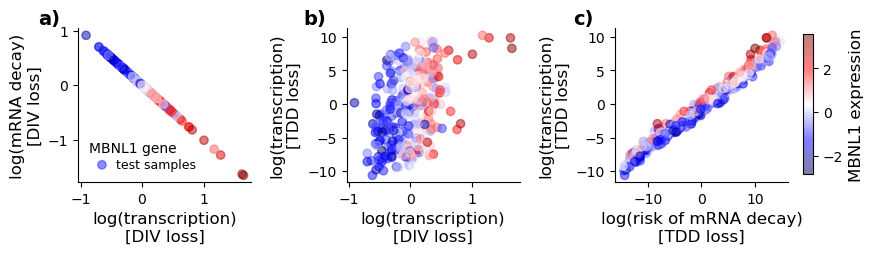

In [176]:
f, ax = plt.subplots(1, 3, figsize=(10,2), gridspec_kw={'wspace':0.55, 'hspace':0.55})

DIV_ID = 28
TRANS_ID = DIV_ID
TDD_ID = DIV_ID

ax[0].scatter(div_trans_test[:,DIV_ID], div_decay_test[:, DIV_ID], c=X_test.values[:, DIV_ID], cmap='seismic', alpha=0.5, label='test samples')
ax[0].set_xlabel('log(transcription)\n[DIV loss]', fontsize=12)
ax[0].set_ylabel('log(mRNA decay)\n[DIV loss]', fontsize=12)
ax[0].legend(title=f'{X_train.columns[DIV_ID]} gene', loc=3, fontsize=9, frameon=False, handletextpad=0.1, labelspacing=0.2, alignment='left')

ax[1].scatter(div_trans_test[:,TRANS_ID], tdd_trans_test[:, TRANS_ID], c=X_test.values[:, TRANS_ID], cmap='seismic', alpha=0.5,  label='test sample')
ax[1].set_xlabel('log(transcription)\n[DIV loss]', fontsize=12)
ax[1].set_ylabel('log(transcription)\n[TDD loss]', fontsize=12)

clb = ax[2].scatter(tdd_risk_test[:, TDD_ID], tdd_trans_test[:, TDD_ID], c=X_test.values[:, TDD_ID], cmap='seismic', alpha=0.5, label='test sample')
ax[2].set_xlabel('log(risk of mRNA decay)\n[TDD loss]', fontsize=12)
ax[2].set_ylabel('log(transcription)\n[TDD loss]', fontsize=12)

f.subplots_adjust(right=0.835)
cbar_ax = f.add_axes([0.85, 0.15, 0.01, 0.7])  # Adjust the [left, bottom, width, height] as needed
cb = f.colorbar(clb, cax=cbar_ax)
cb.set_label(f'{X_train.columns[DIV_ID]} expression', fontsize=12)

from itertools import product
for i in np.arange(3):
    for loc in ['top', 'right']:
        ax[i].spines[loc].set_visible(False)

letters = list('abc')
for i, x in enumerate([0.085, 0.35, 0.62]):
    f.text(x, 0.9, f'{letters[i]})', weight='bold', fontsize=14)


f.savefig(f'../figures/DIV-TDD-output-comparison-one.pdf', bbox_inches='tight', dpi=300)

